In [2]:
import matplotlib
#matplotlib.use('TkAgg')
#!pip install qiskit==0.5.7
import matplotlib.pyplot as plt
import matplotlib.axes as axes

import numpy as np
from scipy import linalg as la
from itertools import permutations
from functools import partial
import networkx as nx

# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
#import Qconfig

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

# import optimization tools
from qiskit.tools.apps.optimization import trial_circuit_ry, SPSA_optimization, SPSA_calibration
from qiskit.tools.apps.optimization import Energy_Estimate, make_Hamiltonian, eval_hamiltonian, group_paulis
from qiskit.tools.qi.pauli import Pauli
import qiskit

# Max-Cut problem

Given a graph $(V,E)$, every $i \sim j \in E$ has its cost $c_{ij}$.  
Cut graph into two parts such that:

$$
\begin{array}{c}{\max \frac{1}{2} \sum_{i<j} c_{i j}\left(1-x_{i} x_{j}\right)} \\ {x_{i} \in\{-1,1\}, \quad i=1, \ldots, n}\end{array}
$$

Equivalent formula:
$$
\begin{array}{c}{\max  \frac{1}{4} x^{T} L x} \\ {x_{i}^{2}=1}\end{array}
$$

Generate Laplacian matrix for a random graph.

In [3]:
import cvxpy as cp
import numpy as np
import scipy as sp
import itertools
import networkx as nx

from tqdm import tqdm_notebook

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import timeit

n = 15
def graph_gen(n=10):
    A = sp.sparse.random(n, n, density=0.4, data_rvs=np.ones)
    upper_X = sp.sparse.triu(A) 
    A = upper_X + upper_X.T
    A = A - sp.sparse.diags(A.diagonal())
    D = sp.sparse.diags(np.array(A.sum(axis=0))[0])
    L = D - A
    G = nx.from_numpy_matrix(A.todense())
    if (not nx.is_connected(G)):
        return graph_gen(n=10)
    return L, A, G

## Naive approach

Grid search alghorithm (naive):

In [4]:
L, A, G = graph_gen(12)

In [5]:
%%time
def naive_max_cut(L):
    n = L.shape[0]
    lst = [list(i) for i in itertools.product([-1, 1], repeat=n)]
    bs = np.argmax(np.array([L.dot(x).dot(x) for x in lst]))
    bs_val = L.dot(lst[bs]).dot(lst[bs]) / 4
    return bs_val, lst[bs]


bs_val, x = naive_max_cut(L)
print("Optimal value for max cut problem is: {:.3f}".format(bs_val))

Optimal value for max cut problem is: 22.000
CPU times: user 144 ms, sys: 835 µs, total: 145 ms
Wall time: 143 ms


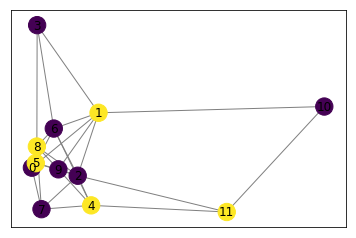

In [6]:
pos = nx.spectral_layout(G)
nx.draw_networkx(G, pos, node_color=x, with_labels=True, vmin=-1, vmax=1, edge_color='gray')

## 2TSC Approximation Algorithm by Luca Trevisan

In [7]:
# Approximation ratio: 0.531
# Complexity: O(n^2)

In [8]:
def first_lemma(G, y):
    """Compute first lemma."""

    numerator = 0.0
    for i in y:
        for j in y:
            if G.has_edge(i, j):
                numerator += abs(y[i] + y[j])

    denominator = 0.0
    for i in y:
        denominator += G.degree(i) * abs(y[i])

    # float division by zero
    if denominator == 0:
        return None
    return numerator / denominator


def second_lemma(G):
    """Compute second lemma."""
    cut_edges = cut_edges(G)
    uncut_edges = G.number_of_edges() - cut_edges

    numerator = float(uncut_edges - cut_edges)
    denominator = float(G.number_of_edges())

    return numerator / denominator


def largest_eigenvector(G):
    """Return the largest eigenvector of a graph G."""
    L = nx.normalized_laplacian_matrix(G)

    eigenvalues, eigenvectors = np.linalg.eig(L.toarray())

    # highest eigenvalue index and ...
    ind = np.argmax(eigenvalues)
    # ... its corresponding eigenvector.
    largest = eigenvectors[:, ind]

    return dict(zip(G, largest))


def two_threshold_spectral_cut(G):
    """Return an indicator vector of a cut computed using the largest
    eigenvector.
    """
    x = largest_eigenvector(G)

    smallest = sign_norm(dict(x))  # all 1 and -1 vector
    min_ratio = first_lemma(G, smallest)

    y = dict.fromkeys(x, 0)

    for k in x:

        for i in x:

            if x[i] < -abs(x[k]):
                y[i] = -1
            elif x[i] > abs(x[k]):
                y[i] = 1
            elif abs(x[i]) <= abs(x[k]):
                y[i] = 0

        # compute first lemma
        ratio = first_lemma(G, y)

        if ratio is not None:
            if min_ratio is None:
                min_ratio, smallest = ratio, dict(y)
            elif ratio < min_ratio:
                min_ratio, smallest = ratio, dict(y)

    # smallest ratio's vector
    return smallest


def recursive_spectral_cut(G):
    """Return an approximate solution to the max cut problem.
    Use the two_threshold_spectral_cut and recursively cut
    the undecided nodes.
    """

    if not G or G.number_of_nodes() == 0:
        return set(), set()

    smallest = two_threshold_spectral_cut(G)

    R = set()
    L = set()
    V = set()

    for i in smallest:
        if smallest[i] == 1:  # blue
            R.add(i)
        elif smallest[i] == 0:  # magenta
            V.add(i)
        elif smallest[i] == -1:  # black
            L.add(i)

    G1 = nx.Graph(nx.subgraph(G, V))

    M = G.number_of_edges() - G1.number_of_edges()
    C = edges_beetween(G, L, R)  # cut edges
    X = edges_beetween(G, L, V) + edges_beetween(G, R, V)

    if C + 0.5 * X <= 0.5 * M or not V:
        if edges_beetween(G, L, R) < G.number_of_edges() / 2:
            return greedy_cut(G)
        return L, R

    if C + 0.5 * X > 0.5 * M:

        # SPECIAL CASE: all undecided nodes (V) are isolate deg = 0
        if is_all_isolate(G1):
            set_partitions(G, L, R)
            visited = (L | R) - V
            B, K = greedy_cut(G, V, visited)
            return L | B, R | K

        V1, V2 = recursive_spectral_cut(G1)

        if (edges_beetween(G, V1 | L, V2 | R) > 
            edges_beetween(G, V1 | R, V2 | L)):
            return V1 | L, V2 | R
        return V1 | R, V2 | L

def sign_norm(d):
    """Normalize dictionary keys according to sign function"""
    sign_d = {}
    for i in d:
        sign_d[i] = np.sign(d[i])
    return sign_d    


def edges_beetween(G, a, b):
    """Return the number of edges between two sets of nodes
    WARNING: a and b should have no element in common.
    """
    return len(list(nx.edge_boundary(G, a, b)))

def set_partitions(G, blue_nodes, black_nodes):
    """Set node's blue class and black class"""

    init_cut(G)
    cut(G, dict.fromkeys(blue_nodes, BLUE))
    cut(G, dict.fromkeys(black_nodes, BLACK))
    
def cut_edges(G, partition_dict=None):
    """Return the value of the cut.
    Cut edges: the number of cross edges between blue and black nodes.
    """
    if partition_dict is not None:
        nbunch = partition_dict.keys()
        cut(G, partition_dict)
    else:
        nbunch = G.nodes()

    blue_nodes, black_nodes, undecided = get_partitions(G, nbunch)[0:3]
    return edges_beetween(G, blue_nodes, black_nodes)


def trevisan_approximation_alg(G):

    B, K = recursive_spectral_cut(G)
    return (B,K)
    # set blue and black nodes in graph G
    #set_partitions(G, B, K)
    #return cut_edges(G)

PARTITION = 'partition'
# Node's classes
BLUE = 1
BLACK = -1

UNDECIDED = 0  # magenta
MARKED = 2 # red

def init_cut(G, nbunch=None):
    """Initialize cut: set all nodes or a bunch of nodes as undecided"""
    if nbunch is None:
        nbunch = G.nodes()

    nx.set_node_attributes(G, PARTITION, dict.fromkeys(nbunch, UNDECIDED))

def integer_to_binary(i, n):
    """Convert an integer to binary."""
    rep = bin(i)[2:]
    return ('0' * (n - len(rep))) + rep


def is_all_isolate(G):
    """Return true if all the nodes in the graph G are isolates"""

    nodes = G.nodes()

    if not nodes:
        return False

    for v in nodes:
        if nx.degree(G, v) != 0:
            return False
    return True

def binary_cut(G, int_cut, bin_cut=None):
    """Cut a graph G using a binary operation."""
    if bin_cut is None:
        bin_cut = integer_to_binary(int_cut, G.number_of_nodes())

    for i, node in enumerate(G.nodes()):
        if bin_cut[i] is '0':
            G.node[node][PARTITION] = BLACK
        else:
            G.node[node][PARTITION] = BLUE

    return nx.get_node_attributes(G, PARTITION)


def partition_dictionary(G):
    """Return a dictionary rapresentation of a cut"""
    return nx.get_node_attributes(G, PARTITION)

def get_partitions(G, nbunch=None):
    """Return all partitions of a graph G as different sets"""

    if nbunch is None:
        nbunch = G.nodes()

    blue_nodes = set()
    black_nodes = set()
    undecided_nodes = set()
    marked_nodes = set()

    for i in nbunch:

        if G.node[i][PARTITION] is BLUE:
            blue_nodes.add(i)

        elif G.node[i][PARTITION] is BLACK:
            black_nodes.add(i)

        elif G.node[i][PARTITION] is MARKED:
            marked_nodes.add(i)

        else:
            undecided_nodes.add(i)

    return (blue_nodes, black_nodes, undecided_nodes, marked_nodes)

def could_be_cut(G, partition_dict):
    """Return true if the graph is being cut according
    to the node's minority class.
    """
    is_cut = False

    for i in partition_dict:
        if partition_dict[i] is UNDECIDED or partition_dict[i] is MARKED:
            node_color = minority_class(G, partition_dict, i)
            if node_color is not UNDECIDED:
                partition_dict[i] = node_color
                is_cut = True

    return is_cut

def minority_class(G, partition_dict, node):
    """Compute the minority class of a node.
    Minority class: tells the class of which a node should belong
    in order to maximize the cut.
    """
    neighbors = G.neighbors(node)

    blue_neighbors = 0
    black_neighbors = 0

    size = len(list(neighbors))

    for i in neighbors:
        if partition_dict[i] is BLUE:
            blue_neighbors += 1
        elif partition_dict[i] is BLACK:
            black_neighbors += 1

    if blue_neighbors > size / 2:
        return BLACK

    if black_neighbors > size / 2:
        return BLUE

    return UNDECIDED


def strong_minority_class(G, partition_dict, node):
    """Compute strong minority class of a node"""
    neighbors = G.neighbors(node)

    blue_neighbors = 0
    black_neighbors = 0

    for i in neighbors:
        if partition_dict[i] is BLUE:
            blue_neighbors += 1
        elif partition_dict[i] is BLACK:
            black_neighbors += 1

    # if all neighbors are marked
    if blue_neighbors == 0 and black_neighbors == 0:
        return MARKED

    if blue_neighbors > black_neighbors:
        return BLACK
    return BLUE


def degree_nodes_sequence(G, nbunch=None, reverse=False):
    """Return a list of nodes in ascending order according to
    their degree value.
    """
    degrees_dict = G.degree(nbunch)
    return sorted(degrees_dict,key=lambda x: x[1],reverse=reverse)
    
def adj_matrix_to_list(l):
    graph = []
    edges = set()
    for i, v in enumerate(l, 1):
        for j, u in enumerate(v, 1):
            if u != 0 and frozenset([i-1, j-1]) not in edges:
                edges.add(frozenset([i-1, j-1]))
                graph.append((i-1,j-1,u))
    return graph

def calculate_optimal_value(A,x):
    first_cut = 0 
    second_cut = 0 
    for idx,val in enumerate(A.toarray()):
        for idxx,vall in enumerate(A.toarray()[idx]):
            if (vall != 0):
                if (x[idx]== x[idxx] and x[idx]==1):
                    first_cut+=1
                if (x[idx]== x[idxx] and x[idx]==0):
                    second_cut+=1
    return max(first_cut,second_cut)

In [9]:
%%time
x = np.zeros(len(A.toarray()))
result = trevisan_approximation_alg(G)
for xx in list(result[0]):
    x[xx]=1
print("Optimal value for max cut problem is: {:.3f}".format(calculate_optimal_value(A,x)))

Optimal value for max cut problem is: 12.000
CPU times: user 7.91 ms, sys: 3.87 ms, total: 11.8 ms
Wall time: 11 ms


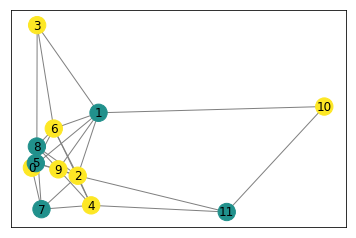

In [10]:
pos = nx.spectral_layout(G)
nx.draw_networkx(G, pos, node_color=x, with_labels=True, vmin=-1, vmax=1, edge_color='gray')

## Enumerative Methods for Maximum Cut's Exact Solutions by Andrea Casini

In [11]:
# Complexity: O(2^n)

In [12]:
def brute_force_max_cut(G):
    "Compute maximum cut of a graph considering all the possible cuts."

    max_cut_value = 0
    max_cut_ind = 0

    n = G.number_of_nodes()

    for i in range(1, 2 ** (n - 1)):
        cut_graph = nx.Graph(G)

        binary_cut(cut_graph, i)
        value = cut_edges(cut_graph)

        if value > max_cut_value:
            max_cut_value = value
            max_cut_ind = i
    binary_cut(G, max_cut_ind)
    return partition_dictionary(G), max_cut_value

In [13]:
%%time
dicti, max_cut_value  = brute_force_max_cut(G)
x  = list(dicti.values())
print("Optimal value for max cut problem is: {:.3f}".format(max_cut_value))

Optimal value for max cut problem is: 22.000
CPU times: user 905 ms, sys: 3.28 ms, total: 908 ms
Wall time: 907 ms


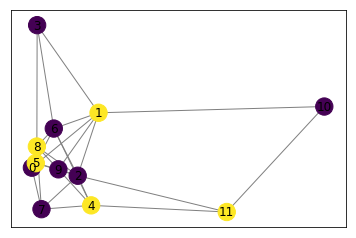

In [14]:
pos = nx.spectral_layout(G)
nx.draw_networkx(G, pos, node_color=x, with_labels=True, vmin=-1, vmax=1, edge_color='gray')

## QUBO - Quantum computing

In [15]:
#https://tc3-japan.github.io/DA_tutorial/tutorial-3-max-cut.html
import numpy as np
import copy


'''
Step 2. Create a Helper Object that can be used to define QUBO 
'''


class BinaryQuadraticPolynomial:
    def __init__(self, n = 1024):

        self.array = np.zeros((n, n), dtype = int)
        self.constant = 0
        self._size = n

    def export_dict(self):
        '''Convert this quadratic polynomial to a dictionary. This is will be called in the DA Solver.'''
        cells = np.where(self.array != 0)
        ts = [{"coefficient": float(self.array[i][j]), "polynomials": [int(i), int(j)]} for i, j in zip(cells[0], cells[1])]
        if self.constant != 0:
            ts.append({"coefficient": float(self.constant), "polynomials": []})
        return {'binary_polynomial': {'terms': ts}}

    def add_coef(self, i, j, c):

        if i > j: # make sure it is an upper triangle matrix.
            t = i
            i = j
            j = t
        assert i >= 0, '[Error] Index out of boundary!'
        assert j < self._size, '[Error] Index out of boundary!'
        self.array[i][j] += c

    def add_constant(self, c):

        self.constant += c

    def add_poly(self, other_quad_poly):

        assert self._size == other_quad_poly._size, '[Error] Array sizes are different!'
        self.array += other_quad_poly.array
        self.constant += other_quad_poly.constant

    def multiply_constant(self, c):

        self.array *= c
        self.constant *= c

    def finalize(self):

        return copy.deepcopy(self)


'''
Step 3. Build Objective Function
'''


def build_max_cut_rule(n_node, edges):

    rule = BinaryQuadraticPolynomial(n_node)
    for (i, j, dij) in edges:
      # dij * (x_i - x_j) ^ 2
        rule.add_coef(i, j, -2 * dij)
        rule.add_coef(i, i, dij)
        rule.add_coef(j, j, dij)
    rule.multiply_constant(-1)
    return rule.finalize()


class Solution:
    def __init__(self, energy=0, frequency=0, configuration=[]):
        self.energy = energy
        self.frequency = frequency
        self.configuration = configuration


def solveDA(rule, da_params):
    '''This is a placeholder'''
    import json
    #print(json.dumps({'da_params': da_params,'rule': rule.export_dict()}))
    dummy_solution = Solution(1, 1, list(np.random.randint(2, size=rule._size)))
    return [dummy_solution]

def find_minimum_solution(da_results):
    minimum = da_results[0].energy
    best_solution = None
    for result in da_results:
        e = result.energy
        s = result
        if minimum <= e:
        #if minimum <= e:
            minimum = e
            best_solution = s
    return best_solution


def make_max_cut_answer(da_results):
    # This is an example.
    solution = find_minimum_solution(da_results)
    return solution.configuration
   #group_1 = []
    #group_2 = []
    #for i, bit in enumerate(solution.configuration):
#        if bit == 0:
 #           group_1.append(i + 1)
#        else:
#            group_2.append(i + 1)
 #   return group_1, group_2


def main(n_node, edges):
    qubo = build_max_cut_rule(n_node, edges)

    # wrapper to call DA API.
    da_results = solveDA(qubo, {
      'number_iterations': 3500000,
      'number_replicas': 52,  # Min: 26, Max: 128
      # Start solving using the initial bits.
      'guidance_config': {str(x): False for x in range(0, qubo._size)},
      'solution_mode': 'COMPLETE'  # QUICK or COMPLETE
    })
    
    # Return the groups of nodes of the max-cut.
    
    return find_minimum_solution(da_results)
    #return make_max_cut_answer(da_results)
    #group_1, group_2 = make_max_cut_answer(da_results)
    #return (group_1, group_2)



In [16]:
%%time
n = len(A.toarray())
adj_list = adj_matrix_to_list(A.toarray())
x = main(n,adj_list).configuration
print("Optimal value for max cut problem is: {:.3f}".format(calculate_optimal_value(A,x)))

Optimal value for max cut problem is: 16.000
CPU times: user 2.5 ms, sys: 0 ns, total: 2.5 ms
Wall time: 1.8 ms


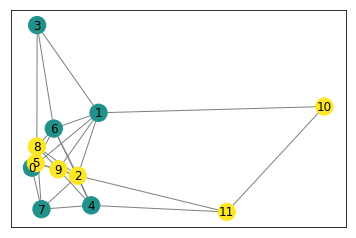

In [17]:
pos = nx.spectral_layout(G)
nx.draw_networkx(G, pos, node_color=x, with_labels=True, vmin=-1, vmax=1, edge_color='gray')

## Upper bound

From [Boyd's extra exercises Book](www.apmath.spbu.ru/cnsa/pdf/monograf/bv_cvxbook_extra_exercises.pdf) we know that upper bound of the problem is given by convex optimization problem:

$$
f(W)=\inf _{\mathbf{1}^{T} x=0} n \lambda_{\max }(L(W)+\operatorname{diag}(x))
$$

$$
\begin{array}{ll}{\text { maximize }} & {\sum_{i \leq j} w_{i j}\left\|p_{i}-p_{j}\right\|_{2}^{2}} \\ {\text { subject }} & {\left\|p_{i}\right\|_{2}=1, \quad i=1, \ldots, n}\end{array}
$$

In [18]:
%%time

def upper_bound_max_cut(L):
    n = L.shape[0]
    x = cp.Variable(n)
    obj = n * cp.lambda_max(L + cp.diag(x))
    constr = [cp.sum(x) == 0]

    problem = cp.Problem(cp.Minimize(obj), constr)
    return problem.solve() / 4, x.value

bs_value, x = upper_bound_max_cut(L)
print("Upper bound: {:.4f}".format(bs_value))

Upper bound: 22.8767
CPU times: user 1.56 s, sys: 30.4 ms, total: 1.59 s
Wall time: 53.2 ms


## Goemans-Williamson

$$
\begin{aligned}
\text{maximize} &\quad \frac14 \langle L, X\rangle  = \frac14 \operatorname{trace}(L X)\\
\text{s.t.}:    &\quad X_{ii}=1 , \; \forall i = \overline{1,n}\\
                &\quad X \succeq 0
\end{aligned}
$$

In [19]:
%%time

def goemans_williamson_max_cut(L):
    n = L.shape[0]
    X = cp.Variable((n, n), PSD=True)

    constr = [cp.diag(X) == np.ones(n)]
    obj = cp.trace(L * X) / 4

    problem = cp.Problem(cp.Maximize(obj), constr)
    
    
    bs_value = problem.solve()
    eps = 1e-3
    V = np.linalg.cholesky(X.value + eps * np.identity(n))

    # xi - random uniform on unit sphere
    normal_deviates = np.random.normal(size=(n, 1))
    radius = np.sqrt((normal_deviates**2).sum(axis=0))
    xi = normal_deviates / radius

    x = np.sign(V.dot(xi))
    bs_val = np.array([L.dot(x).dot(x) / 4 for x in x.T])
    idx_max = np.argmax(bs_val)
    return bs_val[idx_max], x[:, idx_max]

bs_value, x = goemans_williamson_max_cut(L)
print("PSD relaxation {:.3f}".format(bs_value))

PSD relaxation 22.000
CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 36.2 ms


Theoretical results give us:
$$0.87 f^{*} \leq \mathbf{E}_{\xi}\left(\tilde{x}^{T} C \tilde{x}\right) \leq f^{*}$$

## Approx Max-Cut using Local Search

In [20]:
#initilaize random split

def Local_Search_max_cut(L):
    n = L.shape[0]
    np.random.seed()
    x = np.random.choice([-1, 1], size=n)

    bs_value = L.dot(x).dot(x)
#     print("Initial guess gives {:.3f}".format(bs_value / 4))

    improved = True
    while improved :
        improved = False
        for idx in range(n):
            x_new = x.copy()
            x_new[idx] *= -1 #change one index
            new_value = L.dot(x_new).dot(x_new)
            if (new_value > bs_value):
                bs_value = new_value
                x = x_new.copy()
                improved = True
                break
    return bs_value / 4, x

bs_value, x = Local_Search_max_cut(L)
print("Local Search  gives %.3f" % (bs_value)) 

Local Search  gives 22.000


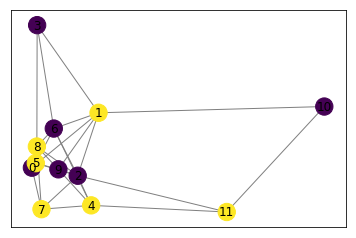

In [21]:
nx.draw_networkx(G, pos, node_color=x, with_labels=True, vmin=-1, vmax=1, edge_color='gray')

## Max-Cut using Greedy Algorithm

In [22]:
def Greedy_Algorithm_max_cut(L):
    n = L.shape[0]
    unused_idxs = np.arange(n)
    np.random.shuffle(unused_idxs)

    used_idxs = []
    x = []
    for idx in unused_idxs:
        used_idxs += [idx]
        x_pos = x.copy() + [1]
        val_pos = L[used_idxs, :][:, used_idxs].dot(x_pos).dot(x_pos)
        x_neg = x.copy() + [-1]
        val_neg = L[used_idxs, :][:, used_idxs].dot(x_neg).dot(x_neg)

        if (val_pos > val_neg):
            x = x_pos.copy()
        else:
            x = x_neg.copy()
    return L.dot(x).dot(x) / 4, x

bs_value, x = Greedy_Algorithm_max_cut(L)
print("Greedy Algorithm  gives:", bs_value)

Greedy Algorithm  gives: 19.0


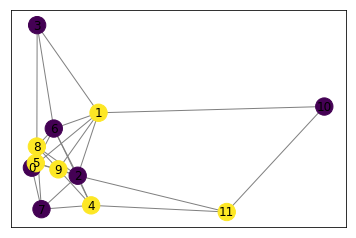

In [23]:
nx.draw_networkx(G, pos, node_color=x, with_labels=True, vmin=-1, vmax=1, edge_color='gray')

## Dual-Scaling

In [24]:
def M(S):
    m = S.shape[0]
    E = np.eye(m)
    M_k = np.zeros((m,m))
    A = np.zeros(m)
    for i in range(m):
        e_i = E[i]
       
        w_i = sp.linalg.solve(S,e_i,sym_pos=True)
        A[i] = np.dot(w_i, e_i)
        M_k[i][i] = A[i] ** 2
        for j in range(i+1,m):
            M_k[i][j] = (w_i @ E[j]) ** 2
    return M_k, A

def dual_scaling(L,eps):
    C =  L.multiply(-0.25)
    n = L.shape[0]
    e = np.ones((1,n))
    #print(e)
    z_k = np.trace(C.T @ np.eye(n))
    #y = np.zeros(n)
    #for i in range(n):
     #   y[i] = C[i][i] - np.sum(np.absolute(C[i])) - 1
    y = C.diagonal() - np.sum(np.absolute(C),axis=1)[np.newaxis, :].T + np.absolute(C.diagonal()) - e
    #print(y)
    S = C - np.diag(np.ravel(y))
    #print(S)
    ro = 5 * n
    alpha = 0.99
    
    gap = (z_k - np.dot(e,y.T)) / (abs((np.dot(e,y.T))) + 1)
    #print(gap)
    #print(z_k)
    while gap >= eps:
        diag_S = np.diag(np.linalg.inv(S))
        M_k, A = M(S)
  
        dy1 = np.linalg.inv(M_k) @ e.T
        dy2 = np.linalg.inv(M_k) @ diag_S
        #print(ro / (z_k -  np.dot(e,y[np.newaxis, :].T)) * dy1)
        dz = np.ravel(np.ravel(ro / (z_k -  np.dot(e,y.T))) * dy1) - dy2
        #print (dz)
        z = np.dot(e,y.T) + (z_k - np.dot(e,y.T)) / ro * (np.dot(diag_S,dz) + n)
        E, V = sp.linalg.eigh(np.diag(dz) + S)
        
        if ((z < z_k) and (np.all(E > -1e-6))):
            #print(0)
            z_k = z
            dz = np.ravel(np.ravel(ro / (z_k -  np.dot(e,y.T))) * dy1) - dy2
        P = np.sqrt(abs(np.dot(ro / (z_k - np.dot(e,y.T)) * e + A,dz)))
        #print(np.dot(ro / (z_k - np.dot(e,y[np.newaxis, :].T)) * e + A,dz))
        y = y + alpha / P * dz
        #print(y)
        S = C - np.diag(np.ravel(y))
        #print(C)
        gap1 = (z_k - np.dot(e,y.T)) / (abs(np.dot(e,y.T)) + 1)
        #print(e)
        #print(np.dot(e,y.T))
        ro = 1.6 * n * np.sqrt(abs(gap / gap1))
        gap = gap1
        #print(gap)
        #print(np.dot(e,y[np.newaxis, :].T))
        #print (gap)
    #print((np.linalg.inv(S) @ (np.diag(dz) + S) @ np.linalg.inv(S)).shape)
    #print(np.linalg.inv(S) @ np.linalg.inv(S))
    #print(np.diag(dz))
    
    diag_S = np.diag(np.linalg.inv(S))
    M_k, A = M(S)
    dy1 = np.linalg.inv(M_k) @ e.T
    dy2 = np.linalg.inv(M_k) @ diag_S
    dz = np.ravel(np.ravel(ro / (z_k - np.dot(e,y.T))) * dy1) - dy2
    z = np.dot(e,y.T) + (z_k - np.dot(e,y.T)) / ro * (np.dot(diag_S,dz) + n)
    
    if ((z < z_k) and (np.all(E > -1e-6))):
        z_k = z
        dz = np.ravel(np.ravel(ro / (z_k -  np.dot(e,y.T))) * dy1) - dy2
    
    X =  np.ravel((z_k - np.dot(e,y.T)) / ro)[0] * np.dot(np.linalg.inv(S),np.dot( (np.diag(dz) + S), np.linalg.inv(S)))
    #print(np.ravel((z_k - np.dot(e,y[np.newaxis, :].T)) / ro)[0])
    return X

## Time comparison

In [77]:
L, A, G = graph_gen(11)

In [78]:
A.toarray()

array([[0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.],
       [0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.]])

In [45]:
N

array([ 4,  5,  8, 13, 19, 28, 43, 64])

In [90]:
np.logspace(4, 8, 10, dtype=int, base=2)

array([ 16,  21,  29,  40,  54,  74, 101, 138, 188, 256])

In [91]:
#Sometimes have to rerun computation
main(10,adj_matrix_to_list(A.toarray()))

AssertionError: [Error] Index out of boundary!

In [37]:
calculate_optimal_value(A, main(n,adj_matrix_to_list(A.toarray())).configuration)

AssertionError: [Error] Index out of boundary!

In [94]:
N = np.logspace(4, 8, 9, dtype=int, base=2)

ub = []
GW = []
LS = []
GA = []
QUBO = []
TSC = []
BFC = []
DS = []
naive = []

for n in tqdm_notebook(N):
    L, A, G = graph_gen(n)
    if (n <= 18):
        naive += [naive_max_cut(L)[0]]
    ub += [upper_bound_max_cut(L)[0]]
    GW += [goemans_williamson_max_cut(L)[0]]
    LS += [Local_Search_max_cut(L)[0]]
    GA += [Greedy_Algorithm_max_cut(L)[0]]
    QUBO += [calculate_optimal_value(A, main(n,adj_matrix_to_list(A.toarray())).configuration)]
    
    x = np.ones(n)
    x[list(trevisan_approximation_alg(G)[0])] = -1
    TSC +=  [L.dot(x).dot(x) / 4]
    x = np.array(-np.sign(dual_scaling(L,1e-7)[0])).flatten()
    DS += [L.dot(x).dot(x) / 4]

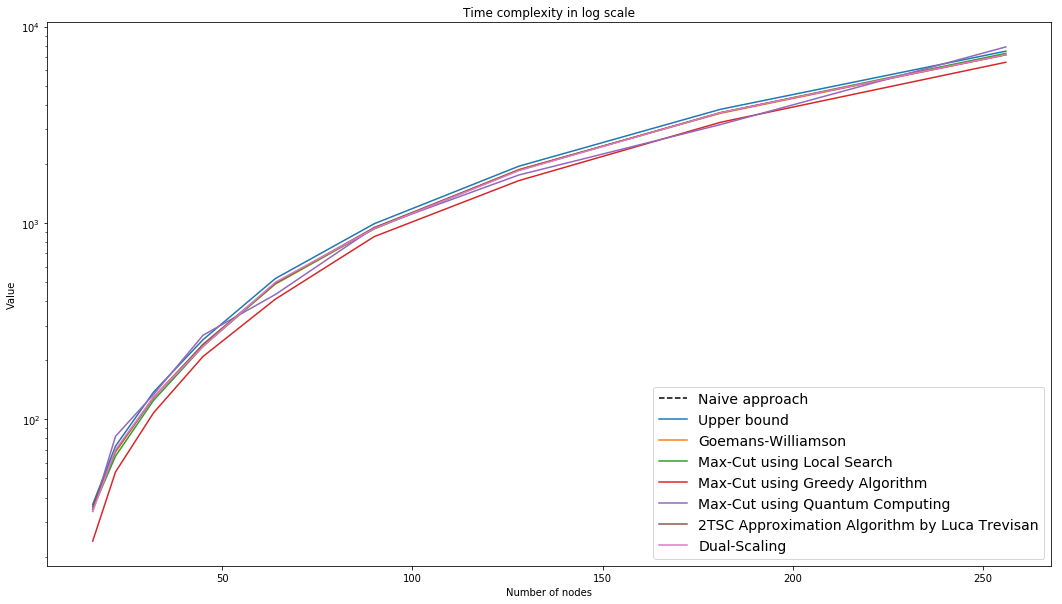

In [95]:
plt.figure(figsize=(18, 10))
plt.title("Time complexity in log scale")
plt.plot(N[:len(naive)], naive, '--', label='Naive approach', color='black')
plt.plot(N, ub, label='Upper bound')
plt.plot(N, GW, label='Goemans-Williamson')
plt.plot(N, LS, label='Max-Cut using Local Search')
plt.plot(N, GA, label='Max-Cut using Greedy Algorithm')
plt.plot(N, QUBO, label='Max-Cut using Quantum Computing')
plt.plot(N, TSC, label='2TSC Approximation Algorithm by Luca Trevisan')
plt.plot(N, DS, label='Dual-Scaling')
# plt.plot(N_naive, BFC, label='Brute Force Cut')
plt.legend(fontsize=14)
plt.ylabel("Value")
plt.xlabel("Number of nodes")
plt.yscale('log')